# TP2 - HISTOGRAMAS, KERNELS & MÉTODOS NO SUPERVISADOS USANDO LA EPH

In [4]:
# Importamos las librerías necesarios para responder el TP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parte I
## Traemos la última base lmpia que utilizamos en el TP1

In [5]:
df_copia = pd.read_csv("df_copia.csv", low_memory=False)

In [6]:
print("Dimensiones base:", df_copia.shape)

Dimensiones base: (16665, 249)


In [7]:
# Seleccionamos las variables de interés
variables_interes = [
    "CH04", "CH06", "CH07", "CH08", "NIVEL_ED",
    "ESTADO", "CAT_INAC", "IPCF", "CAT_OCUP", "PP07H",
    "P21", "CH15", "PP10A", "PP04G", "PP3E_TOT", "CH12", "CH13", "CH14",
    "ITF", "PP3F_TOT"
]

# Parte I - Punto 1

In [8]:
# Limpieza de la variable CH06 (edad)

# Reemplazamos edades negativas o mayores a 100 con NaN
df_copia.loc[(df_copia["CH06"] < 0) | (df_copia["CH06"] > 100), "CH06"] = np.nan

# Mostramos las nuevas estadísticas
print("Resumen estadístico de la edad (tras limpieza):")
print(df_copia["CH06"].describe())

Resumen estadístico de la edad (tras limpieza):
count    16488.000000
mean        36.036390
std         22.420587
min          1.000000
25%         17.000000
50%         33.000000
75%         53.000000
max        100.000000
Name: CH06, dtype: float64


Resumen estadístico de la edad:
count    16488.000000
mean        36.036390
std         22.420587
min          1.000000
25%         17.000000
50%         33.000000
75%         53.000000
max        100.000000
Name: CH06, dtype: float64


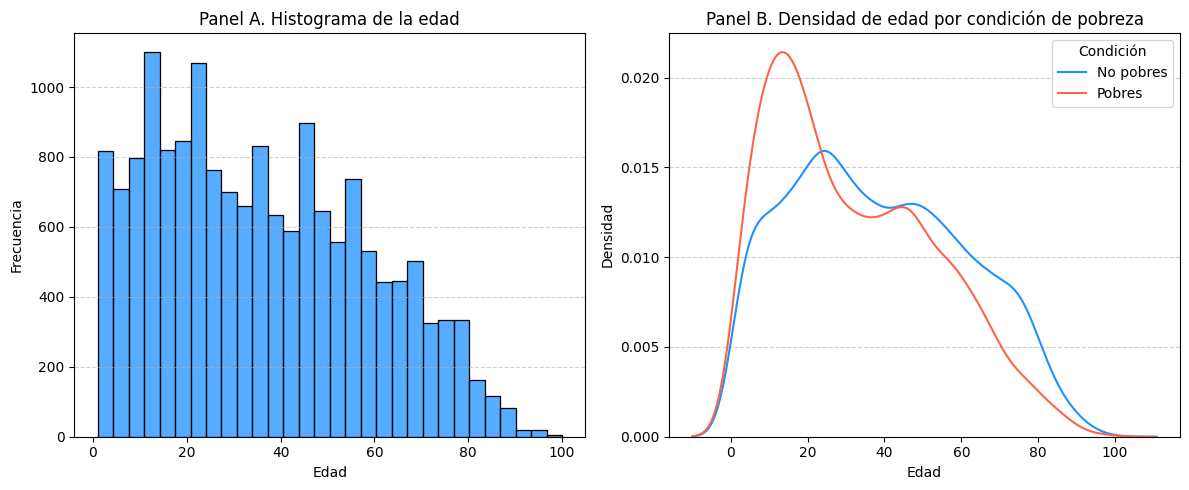

In [9]:
# Creamos la variable edad2
df_copia["edad2"] = df_copia["CH06"] ** 2

# Validamos los valores de edad
print("Resumen estadístico de la edad:")
print(df_copia["CH06"].describe())

# Creamos figura con dos paneles (A y B)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Histograma de edad
sns.histplot(
    data=df_copia,
    x="CH06",
    bins=30,
    kde=False,
    color="#1E90FF",
    ax=axes[0]
)
axes[0].set_title("Panel A. Histograma de la edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Panel B: Distribución kernel por pobreza
sns.kdeplot(
    data=df_copia[df_copia["pobre"] == 0],
    x="CH06",
    fill=False,
    color="#1E90FF",
    label="No pobres",
    ax=axes[1]
)
sns.kdeplot(
    data=df_copia[df_copia["pobre"] == 1],
    x="CH06",
    fill=False,
    color="#FF6347",
    label="Pobres",
    ax=axes[1]
)
axes[1].set_title("Panel B. Densidad de edad por condición de pobreza")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Densidad")
axes[1].legend(title="Condición")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Parte I - Punto 2: Variable 'educ'

In [10]:
#Validamos que CH14 este limpia, ya que nos ha generado conflicto
# Mostramos los valores únicos no numéricos en CH14
valores_no_num = df_copia["CH14"][~df_copia["CH14"].astype(str).str.isnumeric()].unique()
print(valores_no_num)

['  ' '3.0' '1.0' nan '4.0' '2.0' '0.0' '99.0' '5.0' '98.0' '6.0' '7.0'
 '9.0' '8.0']


In [11]:
# Convertimos CH14 a numérica de forma segura
df_copia["CH14"] = pd.to_numeric(df_copia["CH14"], errors="coerce")

# Reemplazamos valores especiales (98, 99) o vacíos por NaN
df_copia.loc[df_copia["CH14"].isin([98, 99]) | df_copia["CH14"].isna(), "CH14"] = np.nan

# Verificamos que todo quedó limpio
print(df_copia["CH14"].describe())

count    7965.000000
mean        2.515756
std         1.974259
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: CH14, dtype: float64


In [12]:
# Mostramos los valores únicos no numéricos en CH14
valores_no_num = df_copia["CH14"][~df_copia["CH14"].astype(str).str.isnumeric()].unique()
print(valores_no_num)

[ 2. nan  5.  0.  1.  4.  3.  7.  6.  9.  8.]


In [13]:
# Creamos la variable 'educ' (años de educación formal)

# Iniciamos la variable vacía
df_copia["educ"] = np.nan

# Casos especiales: educación especial, menores de dos años o jardín sin completar se asignan como 0 años
df_copia.loc[df_copia["CH12"] == 9, "educ"] = 0
df_copia.loc[df_copia["CH06"] < 2, "educ"] = 0
df_copia.loc[(df_copia["CH12"] == 1) & (df_copia["CH13"] == 2), "educ"] = 0

# Nivel primario: asignamos años según el último año aprobado (CH14) si no completó el nivel
cond_prim = (df_copia["CH12"] == 2) & (df_copia["CH13"] == 2)
for i in range(0, 7):
    df_copia.loc[cond_prim & (df_copia["CH14"] == i), "educ"] = 1 + i

# Nivel EGB: tiene hasta 9 años posibles
cond_egb = (df_copia["CH12"] == 3) & (df_copia["CH13"] == 2)
for i in range(0, 9):
    df_copia.loc[cond_egb & (df_copia["CH14"] == i), "educ"] = 1 + i

# Nivel secundario: dura 6 años aproximadamente, se suma a la base acumulada de educación obligatoria
cond_sec = (df_copia["CH12"] == 4) & (df_copia["CH13"] == 2)
for i, val in enumerate([0, 1, 2, 3, 4, 5]):
    df_copia.loc[cond_sec & (df_copia["CH14"] == val), "educ"] = 8 + i

# Nivel polimodal: se asume menor duración (4 años)
cond_poli = (df_copia["CH12"] == 5) & (df_copia["CH13"] == 2)
for i, val in enumerate([0, 1, 2, 3]):
    df_copia.loc[cond_poli & (df_copia["CH14"] == val), "educ"] = 10 + i

# Nivel terciario: se asume una duración promedio de 3 años
cond_terc = (df_copia["CH12"] == 6) & (df_copia["CH13"] == 2)
df_copia.loc[cond_terc & (df_copia["CH14"] == 0), "educ"] = 13
df_copia.loc[cond_terc & (df_copia["CH14"] == 1), "educ"] = 14
df_copia.loc[cond_terc & (df_copia["CH14"].between(2, 97)), "educ"] = 15

# Nivel universitario: se asume una duración promedio de hasta 6 años
cond_univ = (df_copia["CH12"] == 7) & (df_copia["CH13"] == 2)
df_copia.loc[cond_univ & (df_copia["CH14"] == 0), "educ"] = 13
df_copia.loc[cond_univ & (df_copia["CH14"] == 1), "educ"] = 14
df_copia.loc[cond_univ & (df_copia["CH14"] == 2), "educ"] = 15
df_copia.loc[cond_univ & (df_copia["CH14"] == 3), "educ"] = 16
df_copia.loc[cond_univ & (df_copia["CH14"] == 4), "educ"] = 17
df_copia.loc[cond_univ & (df_copia["CH14"].between(5, 97)), "educ"] = 18

# Nivel posgrado: se asume una duración de hasta 4 años adicionales
cond_posg = (df_copia["CH12"] == 8) & (df_copia["CH13"] == 2)
df_copia.loc[cond_posg & (df_copia["CH14"] == 0), "educ"] = 19
df_copia.loc[cond_posg & (df_copia["CH14"] == 1), "educ"] = 20
df_copia.loc[cond_posg & (df_copia["CH14"] == 2), "educ"] = 21
df_copia.loc[cond_posg & (df_copia["CH14"].between(3, 97)), "educ"] = 22

# Casos que completaron el nivel: asignamos los años totales acumulados según el nivel finalizado
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 1), "educ"] = 1
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 2), "educ"] = 8
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 3), "educ"] = 11
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"].isin([4, 5])), "educ"] = 13
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 6), "educ"] = 16
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 7), "educ"] = 19
df_copia.loc[(df_copia["CH13"] == 1) & (df_copia["CH12"] == 8), "educ"] = 23

# Ajustes finales: eliminamos valores imposibles o fuera de rango
df_copia.loc[df_copia["educ"] < 0, "educ"] = np.nan
df_copia.loc[df_copia["educ"] > 23, "educ"] = 23

# Resumen descriptivo de la variable resultante
print("Resumen estadístico de la variable 'educ':")
print(df_copia["educ"].describe(percentiles=[0.5]).round(2))

Resumen estadístico de la variable 'educ':
count    15828.00
mean        10.48
std          5.01
min          0.00
50%         11.00
max         23.00
Name: educ, dtype: float64


# Parte I - Punto 3: Ajuste del ITF

In [14]:

# Copiamos la base
df_ingresos = df_copia.copy()

# --------------------------------------------------------------------
# Definimos los valores de la Canasta Básica Total (CBT)
# Estos valores provienen del TP1 y de la documentación de la EPH:
# - En el primer trimestre de 2005 la CBT para un adulto equivalente fue $205.07.
# - En el primer trimestre de 2025 la CBT fue $365,177.
# Usamos estas cifras para ajustar los ingresos de 2005 a precios de 2025.
# --------------------------------------------------------------------
CBT_2005 = 205.07
CBT_2025 = 365177

# Calculamos el factor de ajuste (cuántas veces aumentó el costo de la CBT)
factor_ajuste = CBT_2025 / CBT_2005

# Mostramos el resultado en pantalla para documentar el ajuste
print("==========================================")
print("Factor de ajuste de precios 2005 → 2025")
print(f"CBT 2005: ${CBT_2005:,.2f}")
print(f"CBT 2025: ${CBT_2025:,.0f}")
print(f"Factor de ajuste: {factor_ajuste:,.1f} veces")
print("==========================================\n")

# Ajustamos los ingresos de 2005 a valores de 2025 usando el factor de precios
df_ingresos["ITF_ajustado"] = np.where(
    df_ingresos["AÑO"] == 2005,
    df_ingresos["ITF"] * factor_ajuste,
    df_ingresos["ITF"]
)


Factor de ajuste de precios 2005 → 2025
CBT 2005: $205.07
CBT 2025: $365,177
Factor de ajuste: 1,780.7 veces



Resumen estadístico del ingreso total familiar (ajustado a 2025):
count       16665.00
mean      2004995.40
std       2816852.15
min             0.00
25%        534222.95
50%       1380000.00
75%       2671114.74
max      92687681.52
Name: ingreso_total_familiar, dtype: float64
Línea de pobreza (ingreso necesario promedio en 2025): $1,055,110



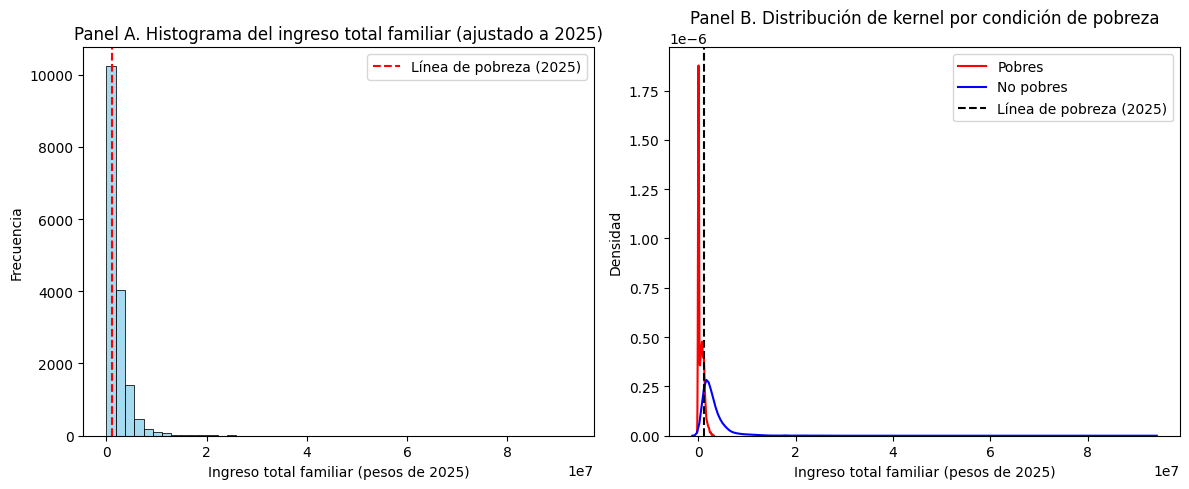

In [15]:
# Creamos una nueva variable con el ingreso total familiar en pesos de 2025
df_ingresos["ingreso_total_familiar"] = df_ingresos["ITF_ajustado"]

# Resumen estadístico general
print("Resumen estadístico del ingreso total familiar (ajustado a 2025):")
print(df_ingresos["ingreso_total_familiar"].describe().round(2))

# Línea de pobreza: usamos la variable 'ingreso_necesario' del TP1,
# que representa el ingreso mínimo requerido por hogar para no ser pobre.
# Calculamos su promedio para graficar como línea de referencia.

linea_pobreza_2025 = df_ingresos.loc[df_ingresos["AÑO"] == 2025, "ingreso_necesario"].mean()
print(f"Línea de pobreza (ingreso necesario promedio en 2025): ${linea_pobreza_2025:,.0f}\n")

# Panel A: Histograma general del ingreso familiar (ajustado a precios de 2025)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(
    df_ingresos["ingreso_total_familiar"],
    bins=50,
    color="skyblue",
    kde=False
)
plt.axvline(linea_pobreza_2025, color="red", linestyle="--", label="Línea de pobreza (2025)")
plt.title("Panel A. Histograma del ingreso total familiar (ajustado a 2025)")
plt.xlabel("Ingreso total familiar (pesos de 2025)")
plt.ylabel("Frecuencia")
plt.legend()


# Panel B: Distribución de kernel por condición de pobreza
# Mostramos las curvas de densidad para pobres y no pobres

plt.subplot(1, 2, 2)
sns.kdeplot(
    data=df_ingresos[df_ingresos["pobre"] == 1],
    x="ingreso_total_familiar",
    color="red",
    label="Pobres"
)
sns.kdeplot(
    data=df_ingresos[df_ingresos["pobre"] == 0],
    x="ingreso_total_familiar",
    color="blue",
    label="No pobres"
)
plt.axvline(linea_pobreza_2025, color="black", linestyle="--", label="Línea de pobreza (2025)")
plt.title("Panel B. Distribución de kernel por condición de pobreza")
plt.xlabel("Ingreso total familiar (pesos de 2025)")
plt.ylabel("Densidad")
plt.legend()

plt.tight_layout()
plt.show()

# Parte 1 - Punto 4: Creación de la variable horastrab y análisis descriptivo

In [ ]:
if()

In [33]:
# Creamos la variable horastrab sumando las horas en la ocupación principal y secundaria
df_ingresos["horastrab"] = np.where(
    df_ingresos["CH07"] == 1,
    df_ingresos["PP3E_TOT"].fillna(0) + df_ingresos["PP3F_TOT"].fillna(0),
    np.nan
)

# Filtramos solo a los jefes de hogar
# Según la EPH, la variable CH07 identifica el parentesco con el jefe del hogar
# En general, CH07 == 1 corresponde al jefe/a del hogar
df_jefes = df_ingresos[df_ingresos["CH07"] == 1].copy()

# Calculamos las estadísticas descriptivas
desc_horas = df_jefes["horastrab"].describe(percentiles=[0.5]).round(2)
print("Estadísticas descriptivas de horas trabajadas (jefes de hogar):")
print(desc_horas)

Estadísticas descriptivas de horas trabajadas (jefes de hogar):
count    2400.00
mean       33.35
std        83.06
min         0.00
50%        29.50
max      1047.00
Name: horastrab, dtype: float64


In [34]:
df_ingresos[df_ingresos["CH07"] != 1]['horastrab'].value_counts()

Series([], Name: count, dtype: int64)

# Parte 1 - Punto 5: Resumen de la base final para Gran Buenos Aires

In [17]:
# Cantidad total de observaciones por año
obs_por_anio = df_copia["AÑO"].value_counts().sort_index()

# Observaciones con valores faltantes en la variable pobre
nas_por_anio = df_copia.groupby("AÑO")["pobre"].apply(lambda x: x.isna().sum())

# Cantidad de pobres y no pobres
pobres_por_anio = df_copia.groupby("AÑO")["pobre"].sum()
no_pobres_por_anio = df_copia.groupby("AÑO")["pobre"].apply(lambda x: (x == 0).sum())

# Cantidad de variables limpias y homogeneizadas
# Suponemos que corresponde al total de columnas sin valores faltantes en cada año
vars_limpias = df_copia.groupby("AÑO").apply(
    lambda x: x.dropna(axis=1, how="any").shape[1]
)

# Creamos el DataFrame resumen
tabla_resumen = pd.DataFrame({
    "Cantidad observaciones": obs_por_anio,
    "Observaciones con NAs en 'pobre'": nas_por_anio,
    "Cantidad de Pobres": pobres_por_anio,
    "Cantidad de No Pobres": no_pobres_por_anio,
    "Variables limpias y homogeneizadas": vars_limpias
}).reset_index().rename(columns={"AÑO": "Año"})

# Agregamos el total general
totales = pd.DataFrame({
    "Año": ["Total"],
    "Cantidad observaciones": [df_copia.shape[0]],
    "Observaciones con NAs en 'pobre'": [df_copia["pobre"].isna().sum()],
    "Cantidad de Pobres": [df_copia["pobre"].sum()],
    "Cantidad de No Pobres": [(df_copia["pobre"] == 0).sum()],
    "Variables limpias y homogeneizadas": [df_copia.dropna(axis=1, how="any").shape[1]]
})

# Unimos los resultados
tabla_resumen = pd.concat([tabla_resumen, totales], ignore_index=True)

# Mostramos la tabla
print("Tabla 1. Resumen de la base final para Gran Buenos Aires")
print(tabla_resumen.to_string(index=False))


Tabla 1. Resumen de la base final para Gran Buenos Aires
  Año  Cantidad observaciones  Observaciones con NAs en 'pobre'  Cantidad de Pobres  Cantidad de No Pobres  Variables limpias y homogeneizadas
 2005                    9484                                 0                2506                   6978                                 173
 2025                    7181                                 0                4204                   2977                                  90
Total                   16665                                 0                6710                   9955                                  67


C:\Users\User\AppData\Local\Temp\ipykernel_18080\2284664935.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vars_limpias = df_copia.groupby("AÑO").apply(


# Parte II : Métodos No Supervisados

Esta parte del trabajo práctico tiene como objetivo que realicen un análisis visual de los datos utilizando las herramientas vistas en clase. En esta parte, solo necesita utilizar las variables: edad, edad2, educ, ingreso_total_familiar (ITF), el número de miembros en el hogar (2005=IX_TOT y 2025=IX_Tot) y horastrab. 
## 1.	Realice una matriz de correlaciones con estos seis predictores para su región y comente los resultados.


In [57]:
# cargamos usu_hogar


df_hogar_2005 = pd.read_stata("data/usu_hogar_T105.dta", convert_categoricals=False)
df_hogar_2025 = pd.read_excel("data/usu_hogar_T125.xlsx")



In [59]:
# Convertimos nombres de columnas de 2005 a mayúsculas
df_hogar_2005.columns = df_hogar_2005.columns.str.upper()

# Convertimos columnas numéricas con decimales innecesarios a enteros cuando sea posible
cols_num = df_hogar_2005.select_dtypes(include=["float", "int"]).columns
for col in cols_num:
    if df_hogar_2005[col].dropna().apply(float.is_integer).all():
        df_hogar_2005[col] = df_hogar_2005[col].astype("Int64")

# Filtramos por la región Gran Buenos Aires (REGION = 1)
df_hogar_2005 = df_hogar_2005[df_hogar_2005["REGION"] == 1].copy()
df_hogar_2025 = df_hogar_2025[df_hogar_2025["REGION"] == 1].copy()

# Agregamos la columna de año
df_hogar_2005["AÑO"] = 2005
df_hogar_2025["AÑO"] = 2025

In [60]:
df_hogar_2005 = df_hogar_2005[["CODUSU", "NRO_HOGAR","IX_TOT","AÑO"]]
df_hogar_2025 = df_hogar_2025[["CODUSU", "NRO_HOGAR","IX_TOT","AÑO"]]

In [61]:
df_hogar = pd.concat([df_hogar_2005, df_hogar_2025], ignore_index=True)

In [62]:
df_hogar

,CODUSU,NRO_HOGAR,IX_TOT,AÑO
0,125098,1,1,2005
1,125188,1,3,2005
2,125242,1,1,2005
3,125436,1,5,2005
4,125533,1,3,2005
...,...,...,...,...
5547,TQRMNOPWQHKLNNCDEIIAD00859137,1,5,2025
5548,TQRMNOPTRHLLNLCDEIIAD00854903,1,1,2025
5549,TQRMNORVUHJLMTCDEIIAD00874347,1,2,2025
5550,TQRMNOPXYHJMNMCDEIIAD00875182,1,4,2025


In [71]:
llaves = ["CODUSU", "NRO_HOGAR","AÑO"]
# Creamos un diccionario para guardar los resultados
resultados_union = {}
# Unión por intersección (inner)
union_inner = pd.merge(df_ingresos, df_hogar, on=llaves, how="inner")
resultados_union["intersección"] = [
    union_inner.shape[0], union_inner.shape[1], union_inner.isna().sum().sum()
]

# Unión por izquierda (left)
union_left = pd.merge(df_ingresos, df_hogar, on=llaves, how="left")
resultados_union["izquierda"] = [
    union_left.shape[0], union_left.shape[1], union_left.isna().sum().sum()
]

# Unión por derecha (right)
union_right = pd.merge(df_ingresos, df_hogar, on=llaves, how="right")
resultados_union["derecha"] = [
    union_right.shape[0], union_right.shape[1], union_right.isna().sum().sum()
]

# Unión conjunta (outer)
union_outer = pd.merge(df_ingresos, df_hogar, on=llaves, how="outer")
resultados_union["conjunta"] = [
    union_outer.shape[0], union_outer.shape[1], union_outer.isna().sum().sum()
]

# Creamos un DataFrame resumen con los resultados
tabla_union = pd.DataFrame.from_dict(
    resultados_union, orient="index", columns=["Nro. de filas", "Nro. de columnas", "Total de NAs"]
)

In [72]:
datos = union_inner.copy()

In [76]:
df_ingresos.shape

(16665, 254)

In [77]:
datos

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,educ,ITF_ajustado,ingreso_total_familiar,horastrab,IX_TOT
0,125098,1,1,1,2005,1,1,S,32,1017,...,0.74,0.74,1.517518e+02,0,6400.0,10.0,1.038173e+06,1.038173e+06,NaN,1
1,125188,1,1,1,2005,1,1,S,32,1062,...,1.00,2.11,4.326977e+02,0,676.0,13.0,8.013344e+05,8.013344e+05,NaN,3
2,125188,1,2,1,2005,1,1,S,32,1062,...,0.76,2.11,4.326977e+02,0,729.0,16.0,8.013344e+05,8.013344e+05,NaN,3
3,125188,1,3,0,2005,1,1,S,32,1062,...,0.35,2.11,4.326977e+02,0,NaN,NaN,8.013344e+05,8.013344e+05,NaN,3
4,125242,1,1,1,2005,1,1,S,32,1103,...,0.67,0.67,1.373969e+02,0,5041.0,8.0,1.522535e+06,1.522535e+06,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16660,TQRMNORWYHKMPRCDEIJAH00860437,1,1,1,2025,1,1,S,33,2798,...,0.83,3.99,1.457056e+06,1,2401.0,NaN,0.000000e+00,0.000000e+00,NaN,5
16661,TQRMNORWYHKMPRCDEIJAH00860437,1,2,1,2025,1,1,S,33,2798,...,0.76,3.99,1.457056e+06,1,2601.0,16.0,0.000000e+00,0.000000e+00,NaN,5
16662,TQRMNORWYHKMPRCDEIJAH00860437,1,3,1,2025,1,1,S,33,2798,...,0.76,3.99,1.457056e+06,1,484.0,16.0,0.000000e+00,0.000000e+00,NaN,5
16663,TQRMNORWYHKMPRCDEIJAH00860437,1,4,1,2025,1,1,S,33,2798,...,1.00,3.99,1.457056e+06,1,676.0,13.0,0.000000e+00,0.000000e+00,NaN,5


In [ ]:
variables = ['CH06', 'edad2', 'educ', 'ingreso_total_familiar', 'IX_TOT', 'horastrab']

In [88]:
datos_filtrados = datos[variables]

# Renombrar columnas en datos_filtrados
datos_filtrados = datos_filtrados.rename(columns={"CH06": "edad", "IX_TOT": "num_miembros_hogar"})




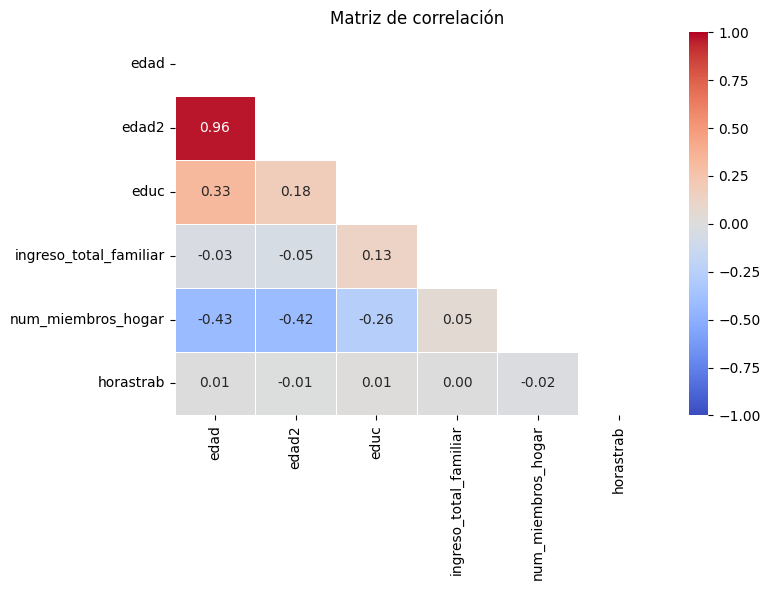

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calcular matriz de correlación 
corr = datos_filtrados.corr()


# Grafico
plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()


## A. PCA

## 2.	PCA con ingreso: Apliquen PCA a las seis variables seleccionadas para esta parte. Recuerde primero estandarizar las variables como vimos en la tutorial. En un gráfico de dispersión muestren los índices (scores) calculados del primer y segundo componente de PCA y comente los resultados. 

In [92]:
# !pip install statsmodels
# !pip install scikit-learn
# !pip install ISLP

Varianza explicada (ratio): [0.3421 0.2309]

Cargas (loadings):
                           PC1    PC2
edad                    0.686 -0.046
edad2                   0.688 -0.058
educ                   -0.055  0.703
ingreso_total_familiar -0.023  0.467
num_miembros_hogar     -0.229 -0.528
horastrab              -0.005  0.066


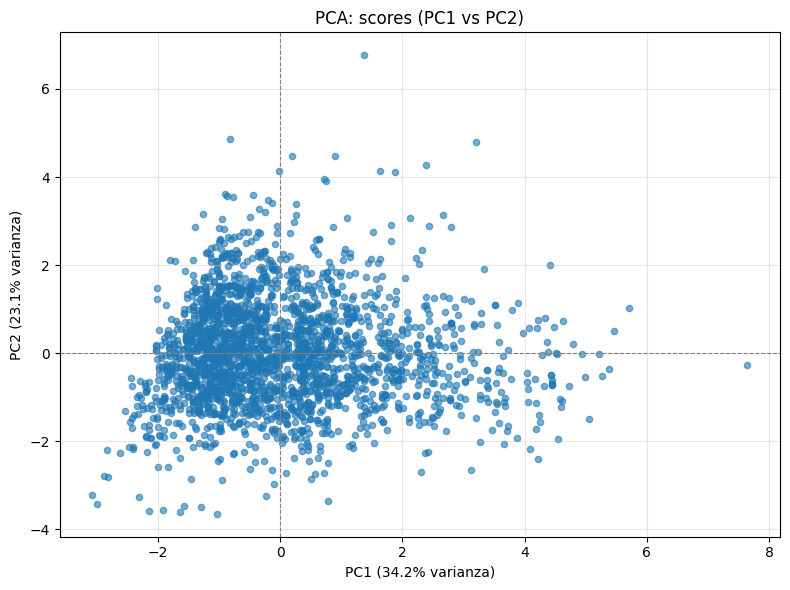

In [94]:
import ISLP
from ISLP import load_data
from statsmodels.datasets import get_rdataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# variables para PCA
vars_pca = ['edad','edad2','educ','ingreso_total_familiar','num_miembros_hogar','horastrab']
#eliminamos nas
df_pca = datos_filtrados[vars_pca].dropna()

# estandarizar
scaler = StandardScaler(with_std=True, with_mean=True)
X_std = scaler.fit_transform(df_pca)

# ajustar PCA (2 componentes para scatter)
pca = PCA(n_components=2)
scores = pca.fit_transform(X_std)

# guardar scores y loadings
df_scores = pd.DataFrame(scores, columns=['PC1','PC2'], index=df_pca.index)
loadings = pd.DataFrame(pca.components_.T, index=vars_pca, columns=['PC1','PC2'])

# agregar scores al dataframe original (solo para filas sin NA)
datos_filtrados = datos_filtrados.join(df_scores)

# imprimir varianza explicada y cargas
print("Varianza explicada (ratio):", np.round(pca.explained_variance_ratio_, 4))
print("\nCargas (loadings):\n", loadings.round(3))

# scatter plot de scores PC1 vs PC2
plt.figure(figsize=(8,6))
plt.scatter(df_scores['PC1'], df_scores['PC2'], s=20, alpha=0.6, color='tab:blue')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
plt.title("PCA: scores (PC1 vs PC2)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


El PC1 explica 34.2% y el PC2 explica 23.9%, esto quiere decir que, con dos componentes ya se captura mas de la mitad de la variabilidad. 

PC1: 
- dominada por edad y edad^2, es un eje ligado a dimension de edad/etapa de vida.
- Cargas: edad 0.686, edad2 0.688 (ambas grandes y positivas). Eso quiere decir que PC1 sube cuando edad y edad2 están por encima de su media. Como edad y edad^2 crecen juntas y edad^2 crece más rápido para edades altas, PC1 se asocia fuertemente con observaciones de mayor edad.
- Las cargas de `ingreso`, `educ` y `horastrab` en PC1 son prácticamente nulas, o leves negativas, por lo que PC1 no refleja el nivel socioeconómico.

PC2:
- representa una dimensión socioeconómica: educación e ingreso cargan positivamente. Mientras que, el número de miembros del hogar carga negativamente.
- `horastrab` tiene carga pequeña en PC2, por lo que aporta poco a esta dimensión.
-  PC2 aumenta cuando educación e ingreso están por encima de su media y disminuye cuando el número de miembros del hogar está por encima de su media. Por tanto, valores altos de PC2 corresponden a individuos con mayor educación y mayor ingreso (y hogares más pequeños); valores bajos a hogares más numerosos con menor educación/ingreso.


## 3.	Grafique con flechas los ponderadores (loading) de PCA para el primer y segundo componente y comente los pesos que que le dan a cada variable utilizada. 

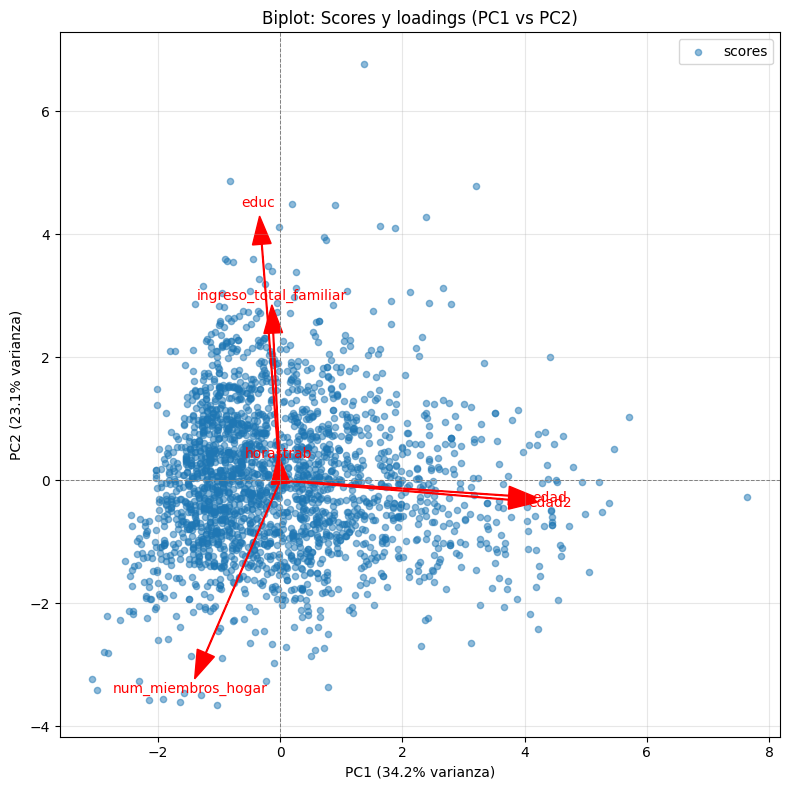

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Biplot: puntos = scores, flechas = loadings (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df_scores['PC1'], df_scores['PC2'], s=20, alpha=0.5, color='tab:blue', label='scores')


# escala proporcional a la dispersión de los scores
scale = max(df_scores.abs().max()) * 0.8

for var in loadings.index:
    x = loadings.loc[var, 'PC1'] * scale
    y = loadings.loc[var, 'PC2'] * scale
    ax.arrow(0, 0, x, y, color='red', width=0.002*scale, head_width=0.05*scale, length_includes_head=True)
    ax.text(x * 1.05, y * 1.05, var, color='red', ha='center', va='center', fontsize=10)

ax.axhline(0, color='grey', linestyle='--', linewidth=0.7)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.7)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
ax.set_title("Biplot: Scores y loadings (PC1 vs PC2)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

- edad (PC1 = 0.686, PC2 = -0.046): fuerte contribución positiva a PC1, sube cuando la edad está por encima de su media y es casi nula en PC2.
- edad2 (PC1 = 0.688, PC2 = -0.058): prácticamente idéntica a edad, nulo en PC2.
- educ (PC1 = -0.055, PC2 = 0.703): contribución muy baja a PC1 y muy alta y positiva a PC2. educ es el principal motor de PC2.
- ingreso_total_familiar (PC1 = -0.023, PC2 = 0.467): casi nulo en PC1 y moderado positivo en PC2. Esto refuerza la interpretación de PC2 como eje socioeconómico, aunque, con menor peso que educ
- num_miembros_hogar (PC1 = -0.229, PC2 = -0.528): carga negativa moderada en PC1 y fuerte negativa en PC2, esto puede indicar que, hogares más numerosos tienden a tener PC2 bajo, es decir, asociado a menor educación/ingres. El signo negativo en PC1 indica una ligera relación inversa con la dimensión edad que captura PC1.
- horastrab (PC1 = -0.005, PC2 = 0.066): prácticamente nula en ambos componentes. Aporta muy poca información a los dos ejes principales.

## 4.	Finalmente, grafique la proporción de la varianza explicada para cada uno de los seis componentes y comente el gráfico. 

Varianza explicada por componente (%):
PC1: 34.21%
PC2: 23.09%
PC3: 16.65%
PC4: 15.70%
PC5: 10.06%
PC6: 0.29%
Varianza explicada acumulada (6 componentes): 100.00%


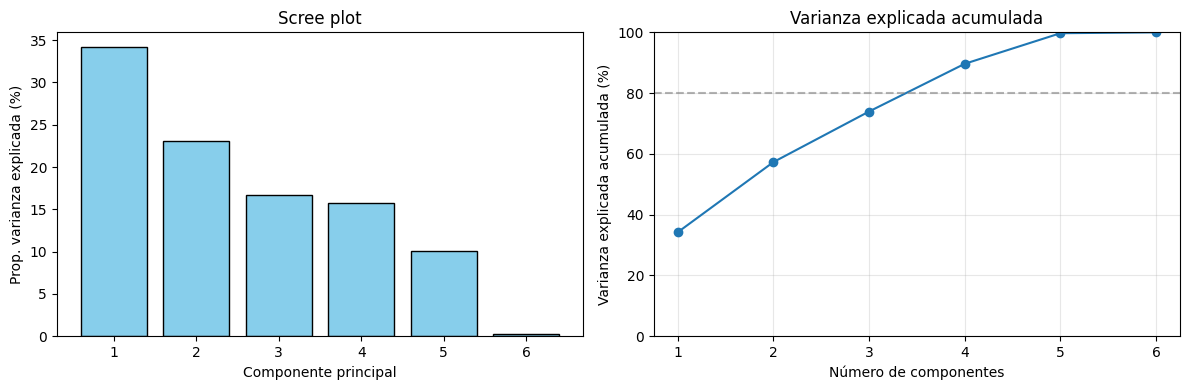

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Ajustar PCA con tantos componentes como variables (6)
pca6 = PCA(n_components=len(vars_pca))
pca6.fit(X_std)
explained = pca6.explained_variance_ratio_
cum_explained = explained.cumsum()

# porcentajes
print("Varianza explicada por componente (%):")
for i, v in enumerate(explained, start=1):
    print(f"PC{i}: {v*100:.2f}%")
print(f"Varianza explicada acumulada (6 componentes): {cum_explained[-1]*100:.2f}%")

# Grafico
components = np.arange(1, len(explained)+1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))


axes[0].bar(components, explained*100, color='skyblue', edgecolor='k')
axes[0].set_xlabel('Componente principal')
axes[0].set_ylabel('Prop. varianza explicada (%)')
axes[0].set_xticks(components)
axes[0].set_title('Scree plot')

# Varianza acumulada
axes[1].plot(components, cum_explained*100, marker='o', color='tab:blue')
axes[1].axhline(80, color='gray', linestyle='--', alpha=0.6)  # referencia 80%
axes[1].set_xlabel('Número de componentes')
axes[1].set_ylabel('Varianza explicada acumulada (%)')
axes[1].set_xticks(components)
axes[1].set_ylim(0, 100)
axes[1].grid(alpha=0.3)
axes[1].set_title('Varianza explicada acumulada')
plt.tight_layout()
plt.show()



En el scree plot se observa que hay una caída fuerte en la varianza explicada entre PC1 y PC2 y luego contribuciones decrecientes. El PC6 aporta prácticamente nada, solo ruido o información redundante ya capturada por las primeras componentes.


Segun la visualización de la varianza explicada acum, 2 componentes (PC1 vs PC2) son suficientes para mostrar más de la mitad de la variabilidad y sirven para explorar patrones/agrupamientos.
Si se toma 4 componentes, estos capturan aprox el 90% de la varianza (buen trade‑off compacidad / pérdida), 5 componentes casi el 100%.

Entonces, si se necesita un índice o reducir dimensionalidad para modelado, 3–4 componentes es una elección razonable; si quiere casi toda la información, usar 5.